In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





# Charger le dataset
chemin_fichier = "C:/Users/ASUS VIVOBOOK X413J/Desktop/data/hotel_booking/hotel_booking.csv"  # Remplacez par le chemin vers votre fichier
df = pd.read_csv(chemin_fichier)

# Afficher le nombre de colonnes
print(f"Nombre de colonnes : {df.shape[1]}")

# Afficher une ligne exemple
print("Exemple d'une ligne :")
print(df.iloc[0])


Nombre de colonnes : 36
Exemple d'une ligne :
hotel                                            Resort Hotel
is_canceled                                                 0
lead_time                                                 342
arrival_date_year                                        2015
arrival_date_month                                       July
arrival_date_week_number                                   27
arrival_date_day_of_month                                   1
stays_in_weekend_nights                                     0
stays_in_week_nights                                        0
adults                                                      2
children                                                  0.0
babies                                                      0
meal                                                       BB
country                                                   PRT
market_segment                                         Direct
distribution_channel    

In [2]:
# Vérifier les valeurs manquantes
missing_values = df.isnull().sum()

# Afficher les colonnes avec le nombre de valeurs manquantes
print("Nombre de valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

# Supprimer la colonne 'company'
df = df.drop(columns=['company'])

# Remplir les valeurs manquantes dans la colonne 'children' avec 0
df['children'] = df['children'].fillna(0)

Nombre de valeurs manquantes par colonne :
children         4
country        488
agent        16340
company     112593
dtype: int64


In [3]:
# Vérifier les lignes dupliquées
duplicates = df[df.duplicated()]

# Afficher les lignes dupliquées
print(duplicates)

# Compter le nombre de doublons
print("Nombre de lignes doublons : ", duplicates.shape[0])


Empty DataFrame
Columns: [hotel, is_canceled, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, arrival_date_day_of_month, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, country, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date, name, email, phone-number, credit_card]
Index: []

[0 rows x 35 columns]
Nombre de lignes doublons :  0


In [4]:
# Afficher les statistiques descriptives pour la colonne "is_canceled"
print(df['is_canceled'].describe())


count    119390.000000
mean          0.370416
std           0.482918
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: is_canceled, dtype: float64


In [5]:
# Remplir les valeurs manquantes par Unkown
df['agent'].fillna('Unknown', inplace=True)
df['country'].fillna("Unknown", inplace=True)

#  Création de nouvelles caractéristiques
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['total_guests'] = df['adults'] + df['children'] + df['babies']
df['cancellation_rate'] = df['previous_cancellations'] / (df['previous_bookings_not_canceled'] + 1)

#  Regroupement des variables numériques en classes (binning)
df['lead_time_bins'] = pd.cut(
    df['lead_time'], 
    bins=[0, 50, 100, 200, 500], 
    labels=['court', 'moyen', 'long', 'très_long']
)

#  Suppression des colonnes non pertinentes ou redondantes
df.drop(['name', 'email', 'phone-number', 'credit_card'], axis=1, inplace=True)

# conversion en datetime
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

print(df.columns)

pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes

# Afficher les 2 premières lignes du DataFrame
print(df.head(2))


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_nights',
       'total_guests', 'cancellation_rate', 'lead_time_bins'],
      dtype='object')
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737              

C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\1615293657.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['agent'].fillna('Unknown', inplace=True)
C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\1615293657.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['agent'].fillna('Unknown', inplace=True)
C:\User

In [6]:
# Colonnes à analyser
columns_to_check = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights', 'days_in_waiting_list']


# Fonction pour remplacer les valeurs négatives par la moyenne des valeurs valides
def replace_negative_with_mean(df):
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Vérifier les colonnes numériques
            mean_valid_values = df[df[col] >= 0][col].mean()  # Moyenne des valeurs >= 0
            df[col] = df[col].apply(lambda x: mean_valid_values if x < 0 else x)
    return df

# Remplacer les valeurs négatives
data = replace_negative_with_mean(df)

print((data[columns_to_check] < 0).sum())




lead_time                  0
adr                        0
stays_in_weekend_nights    0
stays_in_week_nights       0
days_in_waiting_list       0
dtype: int64


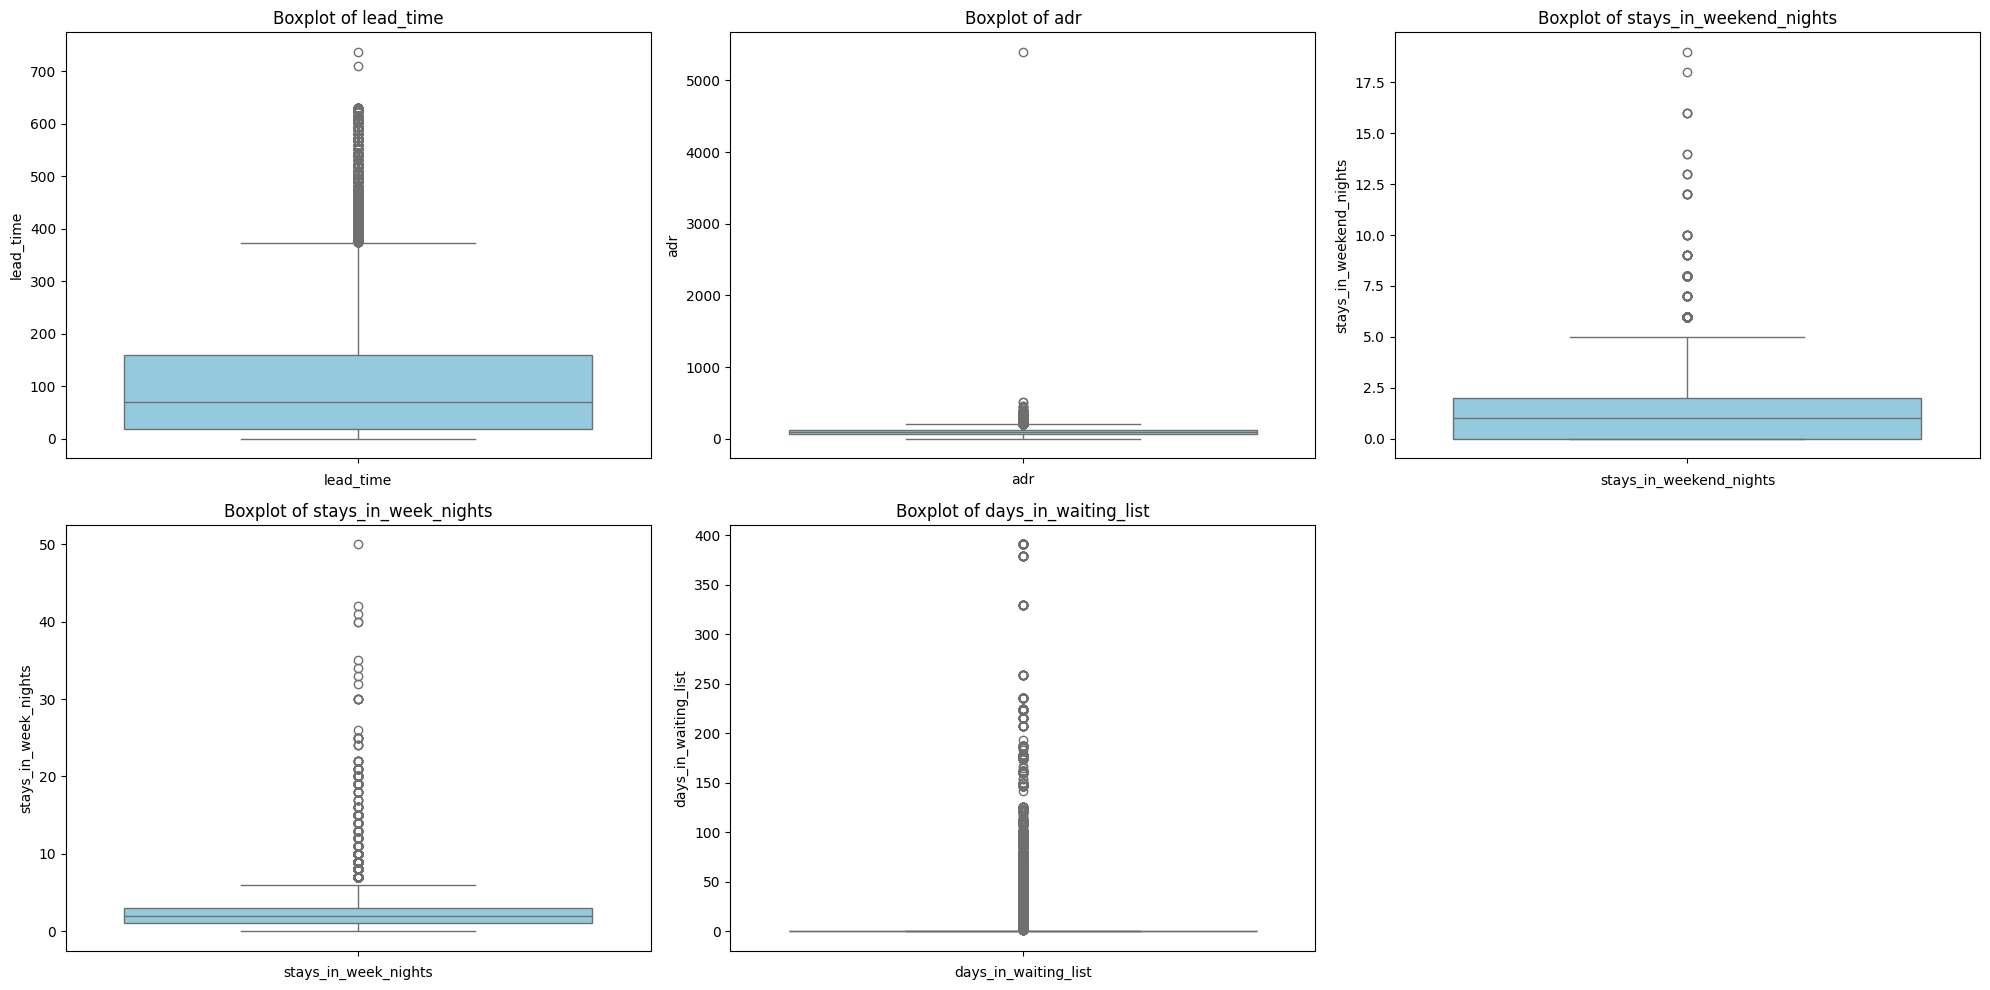

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



outlier_summary = {}

# Visualisation initiale avec boxplots
plt.figure(figsize=(20, 10))
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[col], color='skyblue')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()



In [11]:
for col in columns_to_check:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)  # Fixer un minimum de 0
    upper_bound = Q3 + 1.5 * IQR
    

    # Filtrer les valeurs aberrantes
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_summary[col] = {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outlier Count': outliers.shape[0]
    }

# Supprimer les valeurs aberrantes
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Afficher les résumés des valeurs aberrantes
print("Résumé des valeurs aberrantes après nettoyage :")
for col, summary in outlier_summary.items():
    print(f"\nColumn: {col}")
    for key, value in summary.items():
        print(f"  {key}: {value}")

Résumé des valeurs aberrantes après nettoyage :

Column: lead_time
  Lower Bound: 0
  Upper Bound: 330.0
  Outlier Count: 573

Column: adr
  Lower Bound: 0
  Upper Bound: 201.495
  Outlier Count: 146

Column: stays_in_weekend_nights
  Lower Bound: 0
  Upper Bound: 5.0
  Outlier Count: 0

Column: stays_in_week_nights
  Lower Bound: 0
  Upper Bound: 6.0
  Outlier Count: 0

Column: days_in_waiting_list
  Lower Bound: 0
  Upper Bound: 0.0
  Outlier Count: 0


In [14]:
print(data['days_in_waiting_list'].describe())

count    103096.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: days_in_waiting_list, dtype: float64


In [15]:
df.drop('days_in_waiting_list', axis=1, inplace=True)

In [9]:
# Vérifier les valeurs minimum et maximum après remplacement
print("Min lead_time:", data['lead_time'].min())
print("Max lead_time:", data['lead_time'].max())

Min lead_time: 0
Max lead_time: 373


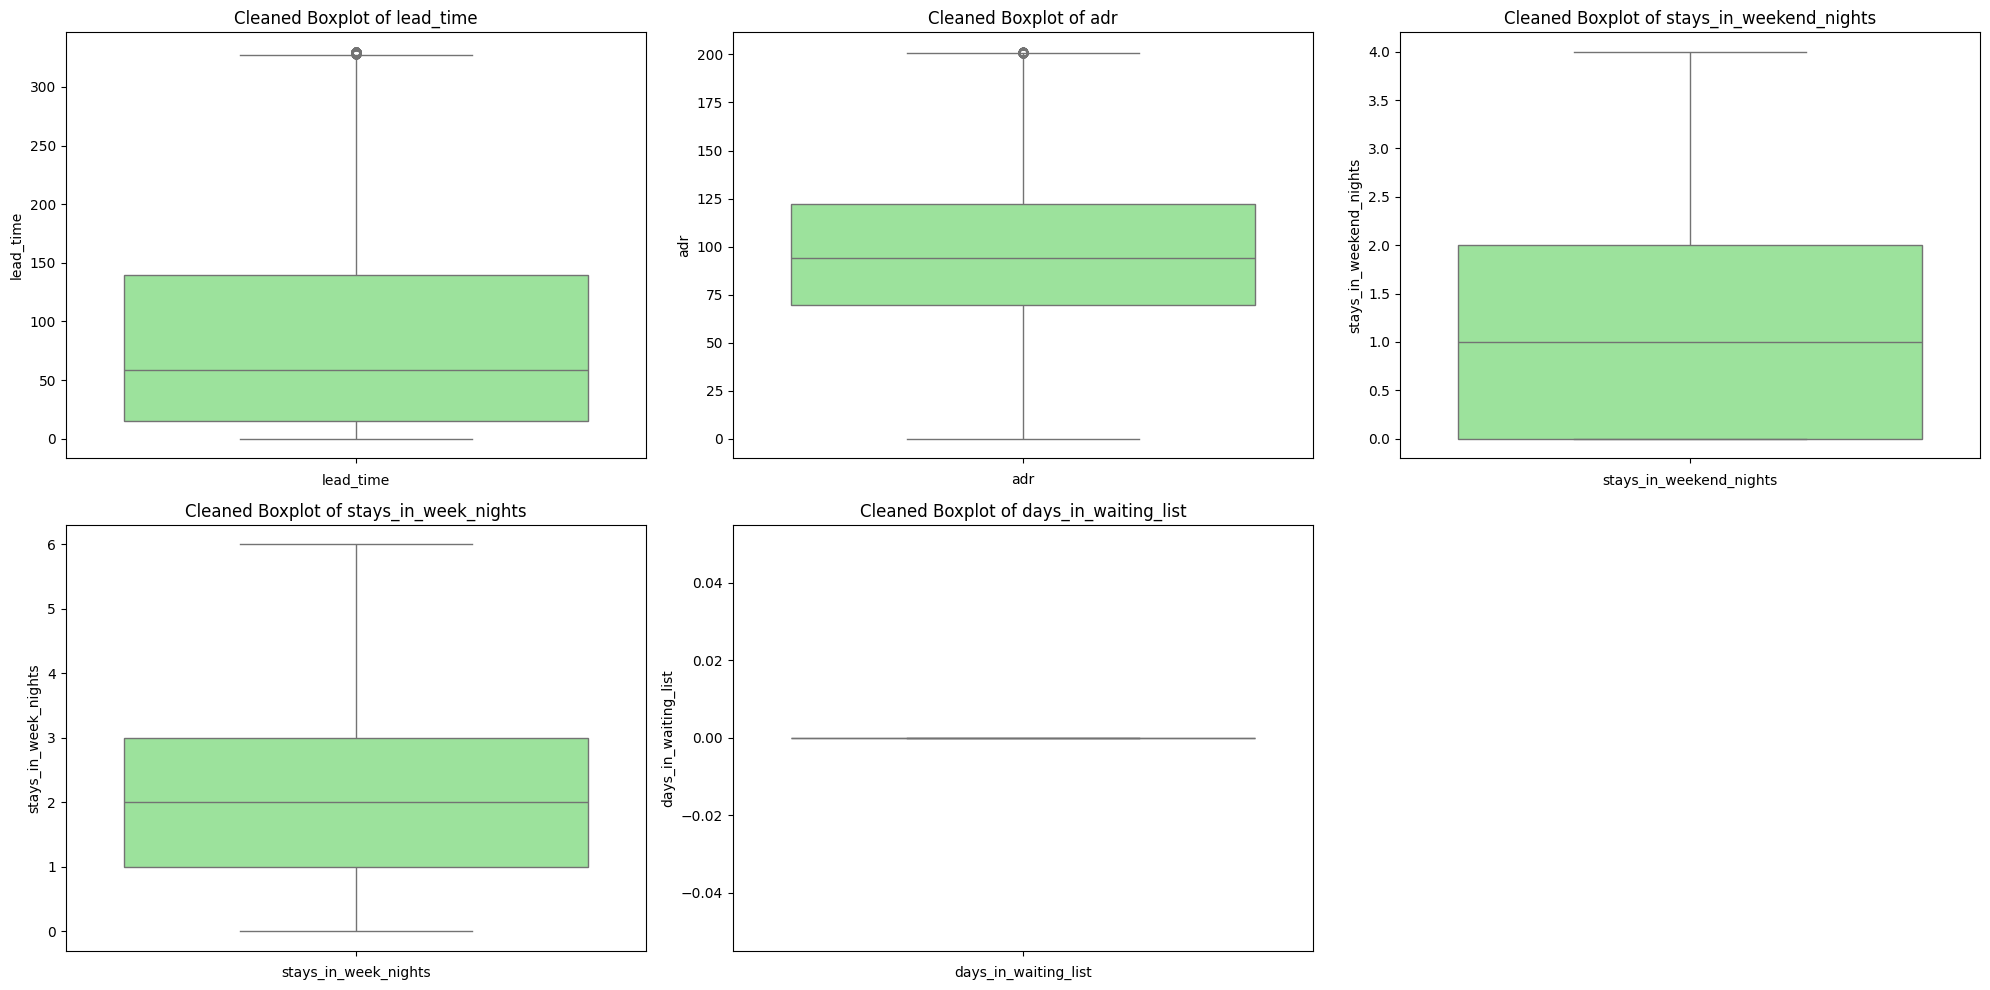

In [13]:
# Visualisation des données nettoyées avec boxplots
plt.figure(figsize=(20, 10))
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[col], color='lightgreen')
    plt.title(f"Cleaned Boxplot of {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [12]:
# Afficher le nombre de lignes et de colonnes dans le fichier nettoyé
rows, cols = data.shape
print(f"Le fichier nettoyé contient {rows} lignes et {cols} colonnes.")


Le fichier nettoyé contient 103096 lignes et 35 colonnes.


In [16]:
# Enregistrer le fichier nettoyé
cleaned_file_path = 'hotel_booking_cleaned.csv'
data.to_csv(cleaned_file_path, index=False)
print(f"Fichier nettoyé enregistré à: {cleaned_file_path}")

Fichier nettoyé enregistré à: hotel_booking_cleaned.csv


C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\514000744.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hotel', y='lead_time', palette='Set2')


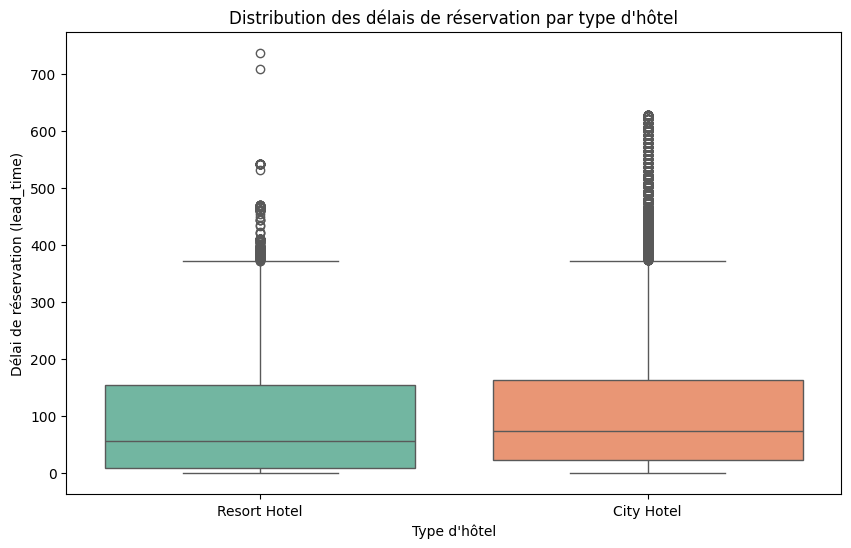

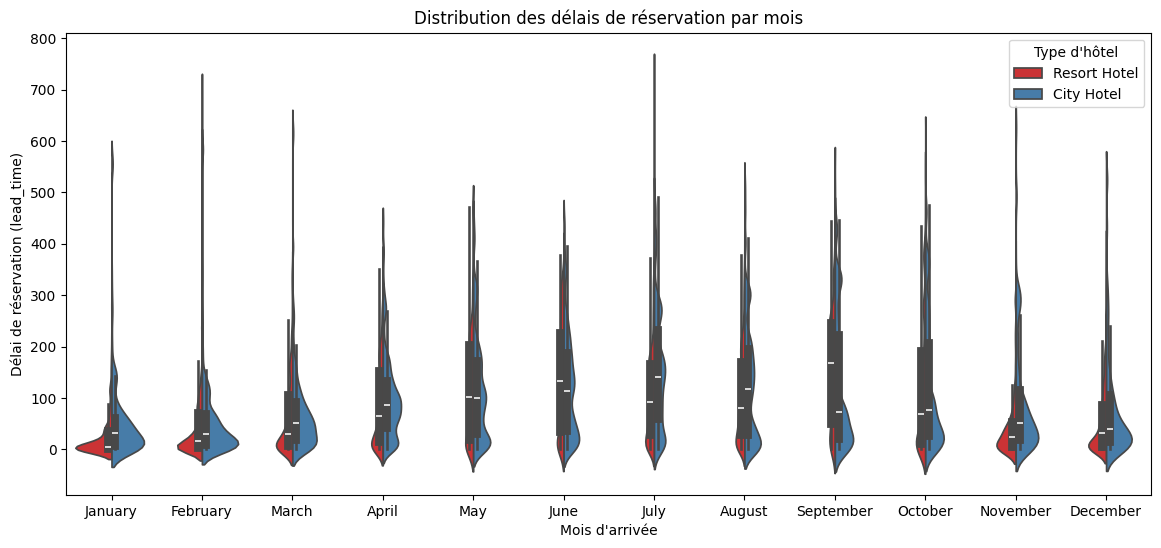


Moyenne des délais de réservation par type d'hôtel et par mois :
           hotel arrival_date_month   lead_time
0     City Hotel            January   56.611884
1     City Hotel           February   52.815307
2     City Hotel              March   73.162744
3     City Hotel              April   99.119519
4     City Hotel                May  116.174441
5     City Hotel               June  124.346972
6     City Hotel               July  153.589639
7     City Hotel             August  130.749527
8     City Hotel          September  127.835000
9     City Hotel            October  125.853254
10    City Hotel           November   94.022493
11    City Hotel           December   84.767183
12  Resort Hotel            January   26.056088
13  Resort Hotel           February   39.930068
14  Resort Hotel              March   64.227518
15  Resort Hotel              April   85.917706
16  Resort Hotel                May  121.050295
17  Resort Hotel               June  138.358621
18  Resort Hotel      

C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\514000744.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_lead_time = df.groupby(['hotel', 'arrival_date_month'])['lead_time'].mean().reset_index()


In [17]:
'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
'''

# Créer une colonne 'arrival_date_month' catégorisée et ordonnée
df['arrival_date_month'] = pd.Categorical(
    df['arrival_date_month'],
    categories=[
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    ordered=True
)

# Distribution des délais de réservation par type d'hôtel (boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='hotel', y='lead_time', palette='Set2')
plt.title("Distribution des délais de réservation par type d'hôtel")
plt.xlabel("Type d'hôtel")
plt.ylabel("Délai de réservation (lead_time)")
plt.show()

# Distribution des délais de réservation par mois et par type d'hôtel (violinplot)
plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x='arrival_date_month', y='lead_time', hue='hotel', split=True, palette='Set1')
plt.title("Distribution des délais de réservation par mois")
plt.xlabel("Mois d'arrivée")
plt.ylabel("Délai de réservation (lead_time)")
plt.legend(title="Type d'hôtel")
plt.show()

# Optionnel : Exporter les résultats analysés
# Exemple : Moyenne des délais de réservation par type d'hôtel et par mois
average_lead_time = df.groupby(['hotel', 'arrival_date_month'])['lead_time'].mean().reset_index()
print("\nMoyenne des délais de réservation par type d'hôtel et par mois :")
print(average_lead_time)

# Exporter les moyennes dans un fichier CSV
average_lead_time.to_csv("average_lead_time_analysis.csv", index=False)

In [18]:
   # Afficher les statistiques descriptives pour la colonne "cancellation_rate"
print(df['cancellation_rate'].describe())



count    119390.000000
mean          0.076406
std           0.806376
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          26.000000
Name: cancellation_rate, dtype: float64


C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\498695263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='hotel', y='cancellation_rate', palette='Set2')


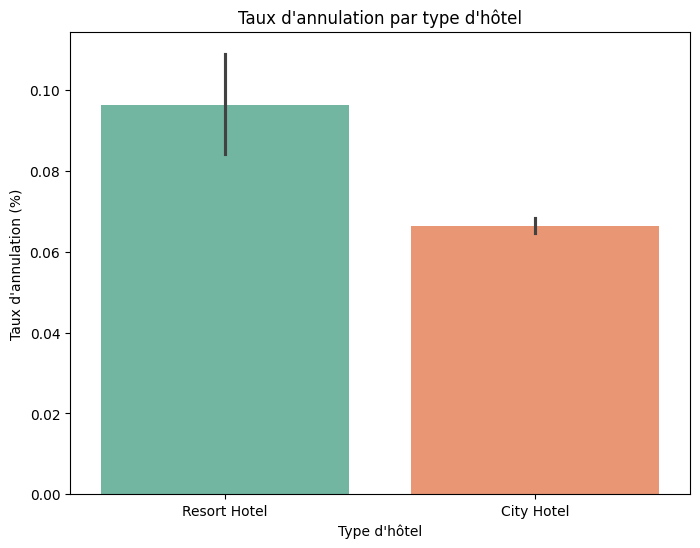

C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\498695263.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='customer_type', y='cancellation_rate', palette='Set3')


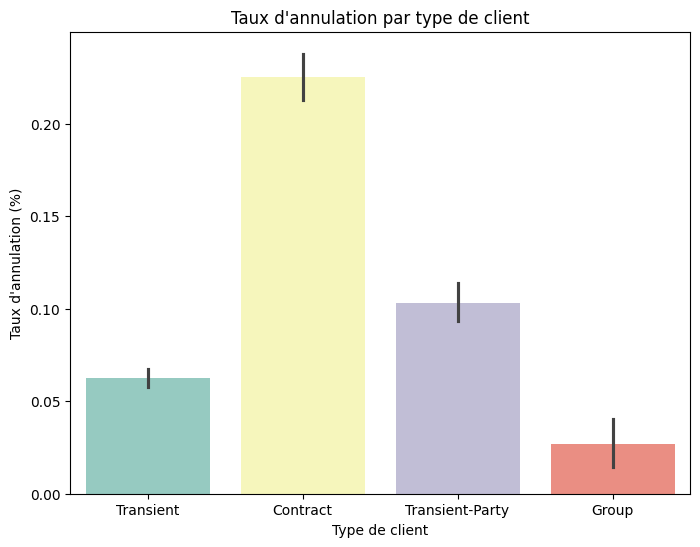

C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\498695263.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='arrival_date_month', y='cancellation_rate', palette='coolwarm')


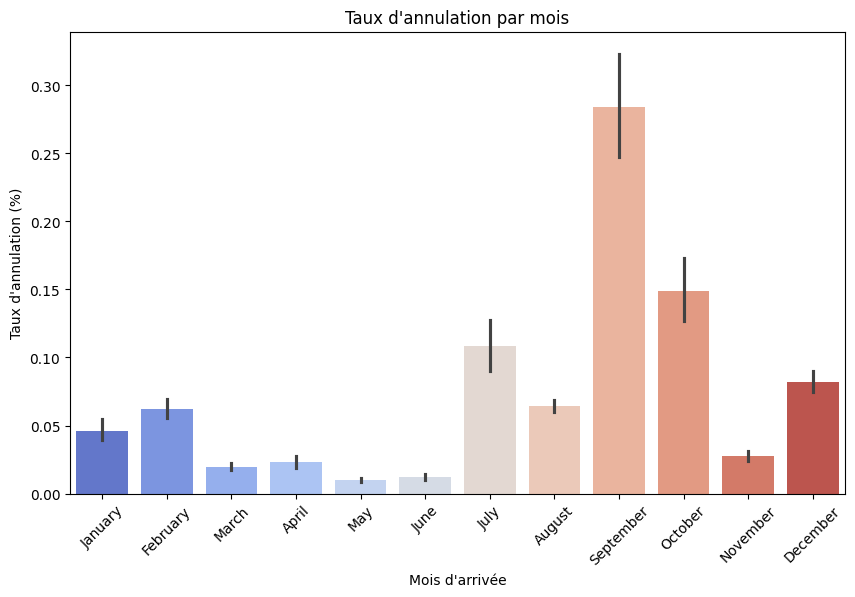

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Visualisation du taux d'annulation par type d'hôtel
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='hotel', y='cancellation_rate', palette='Set2')
plt.title("Taux d'annulation par type d'hôtel")
plt.xlabel("Type d'hôtel")
plt.ylabel("Taux d'annulation (%)")
plt.show()

#  Visualisation du taux d'annulation par type de client
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='customer_type', y='cancellation_rate', palette='Set3')
plt.title("Taux d'annulation par type de client")
plt.xlabel("Type de client")
plt.ylabel("Taux d'annulation (%)")
plt.show()

# Visualisation du taux d'annulation par mois
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='arrival_date_month', y='cancellation_rate', palette='coolwarm')
plt.title("Taux d'annulation par mois")
plt.xlabel("Mois d'arrivée")
plt.ylabel("Taux d'annulation (%)")
plt.xticks(rotation=45)
plt.show()

C:\Users\ASUS VIVOBOOK X413J\AppData\Local\Temp\ipykernel_22316\3378473415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_by_type, x='customer_type', y='revenue', palette='Blues_d')


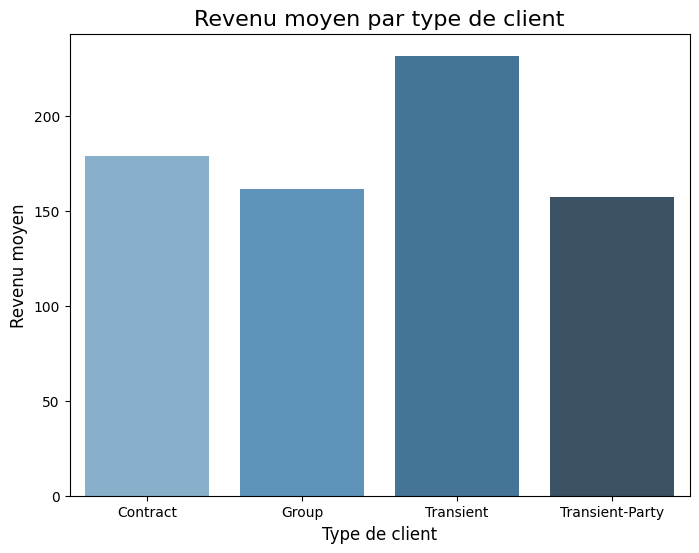

In [20]:


# Calcul du revenu pour chaque ligne (adr * total_guests)
df['revenue'] = df['adr'] * df['total_guests']

# Calcul du revenu moyen par type de client
revenue_by_type = df.groupby('customer_type')['revenue'].mean().reset_index()

# Visualisation avec un barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=revenue_by_type, x='customer_type', y='revenue', palette='Blues_d')

# Titre et labels
plt.title('Revenu moyen par type de client', fontsize=16)
plt.xlabel('Type de client', fontsize=12)
plt.ylabel('Revenu moyen', fontsize=12)

# Affichage du graphique
plt.show()
